# Code to simulate COVID-19 epidemic using a modified stochastic SEIR model to include Asymptomatic, Testing and Quarantine, Hospital and Capacity Effects

## Somnath Mondal

### Ref: Atkins (2010) PhD Dissertation

In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

%matplotlib inline
from IPython.display import display, HTML

print( 'Updated ', dt.datetime.now())

Updated  2020-04-07 22:41:24.992000


### Define Functions for Iteration 
#### (Scroll below for main code)

In [2]:
def update(old_pop, Parameters, change, rate):
    
    beta = Parameters[0]
    delta1 = Parameters[1]
    delta2 = Parameters[2]
    gamma1 = Parameters[3]
    gamma2 = Parameters[4]
    gamma3 = Parameters[5]
    gamma4 = Parameters[6]
    theta = Parameters[7]
    kappa = Parameters[8]
    phi = Parameters[9]
    mu1 = Parameters[10]
    mu2 = Parameters[11]
    mu3 = Parameters[12]
    p_s = Parameters[13]
    p_h = Parameters[14]
    N = Parameters[15]
    H_max = Parameters[16]
    
    S = old_pop[0]
    E = old_pop[1]
    I = old_pop[2]
    A = old_pop[3]
    Q = old_pop[4]
    H = old_pop[5]
    NH = old_pop[6]
    R = old_pop[7]
    D = old_pop[8]
    
    rate[0] = beta*S*(I+delta1*A+delta2*Q)/N 
    rate[1] = p_s*kappa*E
    rate[2] = (1.-p_s)*kappa*E
    rate[3] = gamma2*A
    rate[4] = gamma1*I
    rate[5] = mu1*I
    rate[6] = theta*I
    rate[7] = p_h*phi*I
    rate[8] = gamma1*Q
    rate[9] = mu1*Q
    rate[10] = p_h*phi*Q
    rate[11] = gamma3*H
    rate[12] = mu2*H
    rate[13] = gamma4*NH
    rate[14] = mu3*NH
    
    u1 = np.random.rand()
    u2 = np.random.rand()
    
    if np.sum(rate)>0:
        dt = -np.log(u2)/(np.sum(rate))
    else:
        dt = 0.
    
    event = np.min(np.where(np.cumsum(rate)>=u1*np.sum(rate)))
    
    if H<H_max:
        change[7,:] = [ 0,  0, -1,  0,  0, +1,  0,  0,  0]
        change[10,:]= [ 0,  0,  0,  0, -1, +1,  0,  0,  0]
    else:
        change[7,:] = [ 0,  0, -1,  0,  0,  0, +1,  0,  0]
        change[10,:]= [ 0,  0,  0,  0, -1,  0, +1,  0,  0]
        
    new_pop = old_pop + change[event,:]
    
    return dt, new_pop

    

def Stoch_Iteration(Time, Initial, Parameters):
    
    S = Initial[0]
    E = Initial[1]
    I = Initial[2]
    A = Initial[3]
    Q = Initial[4]
    H = Initial[5]
    NH = Initial[6]
    R = Initial[7]
    D = Initial[8]
    
    change = np.zeros([15, 9])
    H_max = Parameters[16]
    
    ###########     S   E   I   A   Q   H  NH   R   D
    change[0,:] = [-1, +1,  0,  0,  0,  0,  0,  0,  0] 
    change[1,:] = [ 0, -1, +1,  0,  0,  0,  0,  0,  0]
    change[2,:] = [ 0, -1,  0, +1,  0,  0,  0,  0,  0]
    change[3,:] = [ 0,  0,  0, -1,  0,  0,  0, +1,  0]
    change[4,:] = [ 0,  0, -1,  0,  0,  0,  0, +1,  0]
    change[5,:] = [ 0,  0, -1,  0,  0,  0,  0,  0, +1]
    change[6,:] = [ 0,  0, -1,  0, +1,  0,  0,  0,  0]
    change[8,:] = [ 0,  0,  0,  0, -1,  0,  0, +1,  0]
    change[9,:] = [ 0,  0,  0,  0, -1,  0,  0,  0, +1]
    change[11,:]= [ 0,  0,  0,  0,  0, -1,  0, +1,  0]
    change[12,:]= [ 0,  0,  0,  0,  0, -1,  0,  0, +1]
    change[13,:]= [ 0,  0,  0,  0,  0,  0, -1, +1,  0]
    change[14,:]= [ 0,  0,  0,  0,  0,  0, -1,  0, +1]
    
    if H<H_max:
        change[7,:] = [ 0,  0, -1,  0,  0, +1,  0,  0,  0]
        change[10,:]= [ 0,  0,  0,  0, -1, +1,  0,  0,  0]
    else:
        change[7,:] = [ 0,  0, -1,  0,  0,  0, +1,  0,  0]
        change[10,:]= [ 0,  0,  0,  0, -1,  0, +1,  0,  0]
        
       
    T = np.array(([0.],[0.]), dtype=float)
    pop = np.zeros([2,9])
    pop[0,:] = [S, E, I, A, Q, H, NH, R, D]
    old_pop = pop[0,:]
    j = 0
    rate = np.zeros([15]) 
    
    while (T[j]<Time[1]):
        [dt, new_pop] = update(old_pop, Parameters, change, rate)
        j = j + 1
        if dt==0:
            break
        #T = np.append(T, [T[j-1]+dt])
        T[j] = T[j-1]+dt
        pop[j,:] = new_pop
        #pop = np.append((pop, new_pop))
        old_pop = new_pop       
        if j==(np.size(T)-1):
            T = np.append(T,np.zeros_like(T))
            pop = np.append(pop, np.zeros_like(pop),axis=0)
                 
    return T[1:j], pop[1:j,:]


### Initialize Parameters

In [10]:
###### Define Parameters ########
#################################
N = 50000        # total size of population
I0 = 10          # initial number of infected

maxTime = 120     # Total simulation time, in days

beta = 2.34      # contact rate per person per day
delta1 = 1       # reduced infectivity of I_A
delta2 = 0.5     # reduced infectivity of Q
p_s = 0.8        # fraction of E showing symptoms
p_h = 0.05       # fraction of I or Q who become severe
H_max = 500     # max number of hospital beds


## All times are in days and average estimates ###
T_incubation = 5.                    # time for incubation
T_infect_to_recovery = 14.           # time from infection to recovery for I_S
T_infect_to_recovery_asymp = 14.     # time from infection to recovery for I_A
T_hosp_to_recovery = 21.             # time from hospital to recovery
T_nonHosp_to_recovery = 28.          # time from non hospital to recovery
T_infect_to_quarantine = 5.          # time from infected to quarantine
T_hospital = 7.                      # time from I or Q to severe condition
T_death = 28.                        # time from I or Q to death

D_fraction_IQ = 0.1                 # fraction of I or Q who die
D_fraction_H = 0.1                  # fraction of H who die
D_fraction_NH = 0.2                 # fraction of NH who die

#################################
# Initial Population ############
E0 = 0
A0 = 0
Q0 = 0
H0 = 0
NH0 = 0
R0 = 0
D0 = 0

### Main Code

In [11]:
################################

gamma1 = 1./T_infect_to_recovery
gamma2 = 1./T_infect_to_recovery_asymp 
gamma3 = 1./T_hosp_to_recovery
gamma4 = 1./T_nonHosp_to_recovery
theta = 1./T_infect_to_quarantine
kappa = 1./T_incubation
phi = 1./T_hospital

mu1 = D_fraction_IQ/T_death
mu2 = D_fraction_H/(T_death - T_hospital)
mu3 = D_fraction_NH/(T_death - T_hospital)

#################################

S0 = N - I0
Parameters = [beta, delta1, delta2, gamma1, gamma2, gamma3, gamma4, theta, kappa, phi, mu1, mu2, mu3, p_s, p_h, N, H_max]

[T, pop] = Stoch_Iteration([0, maxTime], [S0, E0, I0, A0, Q0, H0, NH0, R0, D0], Parameters)

S = pop[:,0]
E = pop[:,1]
I = pop[:,2]
A = pop[:,3]
Q = pop[:,4]
H = pop[:,5]
NH= pop[:,6]
R = pop[:,7]
D = pop[:,8]

### Plots

Total Population 50000
Initial Infected 10
Max Hospital Bed 500


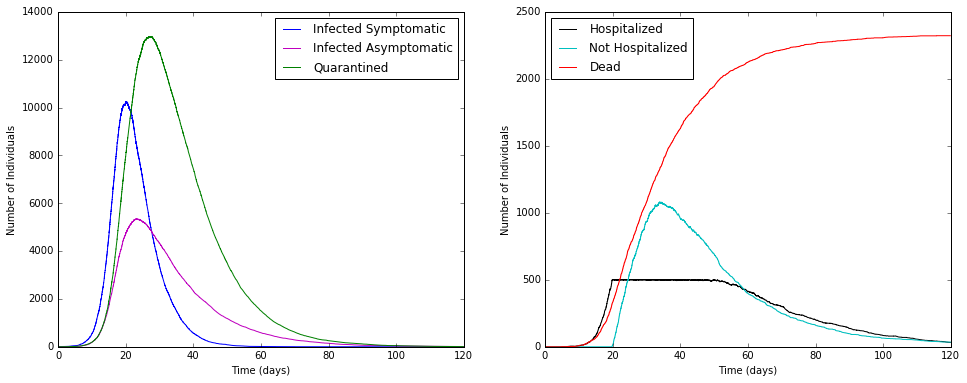

In [29]:
fig, axs = plt.subplots(1, 2,sharex=True, figsize=(16,6))
axs[0].plot(T,I,color='b',label = 'Infected Symptomatic')
axs[0].plot(T,A,color='m',label = 'Infected Asymptomatic')
axs[0].plot(T,Q, color='g',label='Quarantined')
axs[1].plot(T, H, color='k', label='Hospitalized')
axs[1].plot(T, NH, color='c', label='Not Hospitalized')
axs[1].plot(T, D, color='r', label='Dead')

for ax in axs.flat:
    ax.set(xlabel='Time (days)', ylabel='Number of Individuals')
    ax.legend(loc='best')

print("Total Population",N)
print("Initial Infected", I0)
print("Max Hospital Bed", H_max)